# REDES NEURAIS E DEEP LEARNING

# Uso de CNNs para detecção de perfis suspeitos de fraude

## Execução de modelo Random Forest "vanilla" como benchmark

In [2]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics

In [6]:
# Carregando e preparando a base
base_treinamento = pd.read_csv('dataset.csv')

# Fazendo a separação dos dados (variáveis independente e dependente)
X = base_treinamento[[
    'V1',
    'V2',
    'V3',
    'V4',
    'V5',
    'V6',
    'V7',
    'V8',
    'V9',
    'V10',
    'V11',
    'V12',
    'V13',
    'V14',
    'V15',
    'V16',
    'V17',
    'V18',
    'V19',
]]

y = base_treinamento['Class']

# Garantindo que não existem NAs para não termos problemas na modelagem.
X.fillna(0, inplace=True)

# Transformando tudo para float
x = X.astype(float)

C:\Users\cmcf7\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\frame.py:4323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


<AxesSubplot:xlabel='Class', ylabel='count'>

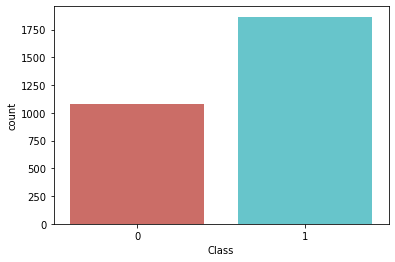

In [7]:
# Verificando o balanceamento do problema
base_treinamento['Class'].value_counts()
sns.countplot(x='Class', data=base_treinamento, palette='hls')
#plt.show()

In [8]:
# Separando os dados de treino e teste para o modelo
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20)

In [13]:
# Aplicando um modelo Random Forest "vanilla", com todos os parâmetros padrão de aplicação.
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train,y_train)

# Avaliando uma única execução
y_pred_teste = clf.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred_teste))
print(metrics.classification_report(y_test, y_pred_teste,
                                    target_names=['Saudavel','Suspeito']))
print('Accuracy:', '{0:.1f}%'.format(metrics.accuracy_score(y_test, y_pred_teste)*100))
print('Precision:', '{0:.1f}%'.format(metrics.precision_score(y_test, y_pred_teste)*100))
print('Recall:', '{0:.1f}%'.format(metrics.recall_score(y_test, y_pred_teste)*100))

[[128  91]
 [ 61 309]]
              precision    recall  f1-score   support

    Saudavel       0.68      0.58      0.63       219
    Suspeito       0.77      0.84      0.80       370

    accuracy                           0.74       589
   macro avg       0.72      0.71      0.72       589
weighted avg       0.74      0.74      0.74       589

Accuracy: 74.2%
Precision: 77.2%
Recall: 83.5%


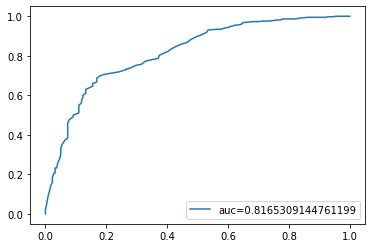

In [14]:
# Curva ROC.
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
#plt.show()

## Transformando dados em imagens

### Referência
https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

In [1]:
# Importando bibliotecas
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
import cv2
#import matplotlib.pyplot as plt
import seaborn as sns


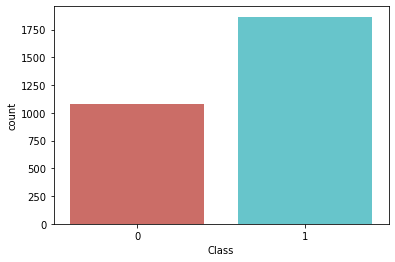

In [2]:
# Preparando os dados
base_path = "dataset.csv"
dt_Treino = pd.read_csv(base_path)

# Verificando o balanceamento do problema original
dt_Treino['Class'].value_counts()
sns.countplot(x='Class', data=dt_Treino, palette='hls')

# Reindexando o DF.
dt_Treino.reset_index(drop=True ,inplace=True)

In [18]:
# Gerando e salvando imagens de dados de treino.
for index, row in dt_Treino.iterrows():
    tamanho = len(dt_Treino)
    dt_target = row['Class'].astype(int).astype(str)
    xTrain = row.iloc[0:19]
    
    # Convertendo o DF em um NP Array.
    xT_np = xTrain.to_numpy()
    # Normalizando o array
    norm_image = cv2.normalize(xT_np, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # Garantindo que o array está em unsigned int 8 (0-255)
    norm_image = norm_image.astype(np.uint8)
    
    # Gerando imagens ampliadas (2x)
    w, h = 19, 1
    img = Image.fromarray(norm_image, 'L')
    newsize = (2*w,38*h)
    img = img.resize(newsize)
    # Criando o nome para as imagens e salvando nos respectivos diretórios.
    if dt_target == '0':
        nome_img = './/imagens//train//saud//' + str(index) + '_train_' + dt_target + '.png'
    else:
        nome_img = './/imagens//train//fraud//' + str(index) + '_train_' + dt_target + '.png'
    #print('imagem',index,'de',tamanho)
    bimg = ImageOps.expand(img)
    bimg.save(nome_img, format='PNG')
    #img.show()

print('Feito!')

Feito!


## Executando o modelo CNN

### Referência
Carregando imagens para o modelo com o ImageDataGenerator do Keras.

https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

In [3]:
# Importando bibliotecas
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers,callbacks
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [13]:
# LeNet-5 architecture
# Inicialmente, execução "vanilla"
# Depois, tentativa de melhora do overfitting com as seguintes alterações:
#   - Inclusão de Dropouts
#   - Alteração dos filtros de 6 para 8 na primeira convolução 
def build(formato_entrada, classes, nome):
    model = Sequential()
    model._name = nome
    model.add(layers.Conv2D(filters=8, 
                            kernel_size=(3,3),
                            activation='relu',
                            input_shape=formato_entrada))
    model.add(layers.AveragePooling2D())
    
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(filters=16,
                            kernel_size=(3,3),
                            activation='relu'))
    model.add(layers.AveragePooling2D())
    
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(units=120, activation='relu'))
    model.add(layers.Dense(units=84, activation='relu'))
    model.add(layers.Dense(classes, activation='sigmoid'))
    return model

In [5]:
# Definições
BATCH_SIZE = 64
NOME_MODELO = 'LeNet-5'

# Dimensão das imagens de entrada
IMG_ROWS, IMG_COLS = 38, 38 
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 1)
# Neurônios saída
NB_OUTPUT = 1

In [6]:
# Carregando as imagens dos arquivos e convertendo para entrada do modelo
# Instanciando o generator
datagen = ImageDataGenerator(#featurewise_std_normalization=True,
                             validation_split=0.3)

# Preparando iterators para os conjuntos de dados
train_it = datagen.flow_from_directory('.//imagens//train//', 
                                       class_mode='binary',
                                       target_size=(IMG_ROWS,IMG_COLS),
                                       color_mode='grayscale',
                                       subset='training',
                                       batch_size=BATCH_SIZE)
val_it = datagen.flow_from_directory('.//imagens//train//', 
                                        class_mode='binary',
                                        target_size=(IMG_ROWS,IMG_COLS),
                                        color_mode='grayscale',
                                        subset='validation',
                                        batch_size=BATCH_SIZE)

Found 2061 images belonging to 2 classes.
Found 882 images belonging to 2 classes.


In [14]:
# Montagem do modelo
model = build(formato_entrada=INPUT_SHAPE, classes=NB_OUTPUT, nome=NOME_MODELO)

# Opções do modelo
model.compile(loss='binary_crossentropy', 
              optimizer='Adam',
              metrics=["accuracy"])

# Definindo checkpoints
filepath=".//checkpoint//best_model.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='accuracy', 
                                       verbose=1, save_best_only=True, 
                                       mode='max')
callbacks_list = [checkpoint]

In [15]:
# Fit do modelo
history = model.fit(train_it, epochs=500, 
                    verbose=0, 
                    validation_data=val_it,
                    steps_per_epoch=train_it.n//train_it.batch_size,
                    validation_steps=val_it.n//val_it.batch_size,
                    callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: accuracy improved from -inf to 0.58388, saving model to .//checkpoint//best_model.hdf5

Epoch 00002: accuracy did not improve from 0.58388

Epoch 00003: accuracy improved from 0.58388 to 0.59089, saving model to .//checkpoint//best_model.hdf5

Epoch 00004: accuracy improved from 0.59089 to 0.59339, saving model to .//checkpoint//best_model.hdf5

Epoch 00005: accuracy improved from 0.59339 to 0.61292, saving model to .//checkpoint//best_model.hdf5

Epoch 00006: accuracy did not improve from 0.61292

Epoch 00007: accuracy improved from 0.61292 to 0.62293, saving model to .//checkpoint//best_model.hdf5

Epoch 00008: accuracy improved from 0.62293 to 0.62544, saving model to .//checkpoint//best_model.hdf5

Epoch 00009: accuracy improved from 0.62544 to 0.63295, saving model to .//checkpoint//best_model.hdf5

Epoch 00010: accuracy did not improve from 0.63295

Epoch 00011: accuracy improved from 0.63295 to 0.64747, saving model


Epoch 00127: accuracy improved from 0.72459 to 0.72709, saving model to .//checkpoint//best_model.hdf5

Epoch 00128: accuracy did not improve from 0.72709

Epoch 00129: accuracy did not improve from 0.72709

Epoch 00130: accuracy did not improve from 0.72709

Epoch 00131: accuracy improved from 0.72709 to 0.72754, saving model to .//checkpoint//best_model.hdf5

Epoch 00132: accuracy did not improve from 0.72754

Epoch 00133: accuracy did not improve from 0.72754

Epoch 00134: accuracy did not improve from 0.72754

Epoch 00135: accuracy did not improve from 0.72754

Epoch 00136: accuracy did not improve from 0.72754

Epoch 00137: accuracy did not improve from 0.72754

Epoch 00138: accuracy did not improve from 0.72754

Epoch 00139: accuracy did not improve from 0.72754

Epoch 00140: accuracy did not improve from 0.72754

Epoch 00141: accuracy did not improve from 0.72754

Epoch 00142: accuracy did not improve from 0.72754

Epoch 00143: accuracy improved from 0.72754 to 0.72909, saving 


Epoch 00268: accuracy did not improve from 0.76665

Epoch 00269: accuracy did not improve from 0.76665

Epoch 00270: accuracy did not improve from 0.76665

Epoch 00271: accuracy did not improve from 0.76665

Epoch 00272: accuracy did not improve from 0.76665

Epoch 00273: accuracy improved from 0.76665 to 0.76915, saving model to .//checkpoint//best_model.hdf5

Epoch 00274: accuracy did not improve from 0.76915

Epoch 00275: accuracy did not improve from 0.76915

Epoch 00276: accuracy did not improve from 0.76915

Epoch 00277: accuracy did not improve from 0.76915

Epoch 00278: accuracy did not improve from 0.76915

Epoch 00279: accuracy did not improve from 0.76915

Epoch 00280: accuracy did not improve from 0.76915

Epoch 00281: accuracy did not improve from 0.76915

Epoch 00282: accuracy improved from 0.76915 to 0.77666, saving model to .//checkpoint//best_model.hdf5

Epoch 00283: accuracy did not improve from 0.77666

Epoch 00284: accuracy did not improve from 0.77666

Epoch 00285


Epoch 00414: accuracy did not improve from 0.81823

Epoch 00415: accuracy did not improve from 0.81823

Epoch 00416: accuracy did not improve from 0.81823

Epoch 00417: accuracy did not improve from 0.81823

Epoch 00418: accuracy did not improve from 0.81823

Epoch 00419: accuracy did not improve from 0.81823

Epoch 00420: accuracy did not improve from 0.81823

Epoch 00421: accuracy did not improve from 0.81823

Epoch 00422: accuracy did not improve from 0.81823

Epoch 00423: accuracy did not improve from 0.81823

Epoch 00424: accuracy did not improve from 0.81823

Epoch 00425: accuracy did not improve from 0.81823

Epoch 00426: accuracy did not improve from 0.81823

Epoch 00427: accuracy did not improve from 0.81823

Epoch 00428: accuracy did not improve from 0.81823

Epoch 00429: accuracy did not improve from 0.81823

Epoch 00430: accuracy did not improve from 0.81823

Epoch 00431: accuracy did not improve from 0.81823

Epoch 00432: accuracy did not improve from 0.81823

Epoch 00433

In [16]:
# Apresentando a estrutura do modelo.
model.summary()

Model: "LeNet-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 36, 36, 8)         80        
_________________________________________________________________
average_pooling2d_2 (Average (None, 18, 18, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
average_pooling2d_3 (Average (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0   

In [17]:
# Resumo de resultados
print('#### MODELO:'+ NOME_MODELO +' ####')
print('#### RESULTADOS ####')
print('#### TREINO ####')
print('Max train accuracy:', '{0:.2f}%'.format(np.max(history.history['accuracy'])*100))
print('#### VALIDAÇÃO ####')
print('Max validation accuracy:', '{0:.2f}%'.format(np.max(history.history['val_accuracy'])*100))

#### MODELO:LeNet-5 ####
#### RESULTADOS ####
#### TREINO ####
Max train accuracy: 83.73%
#### VALIDAÇÃO ####
Max validation accuracy: 69.71%


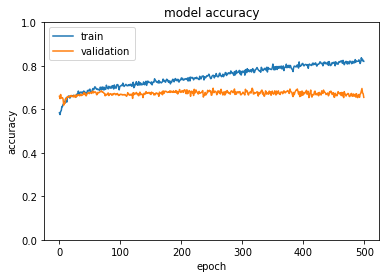

In [18]:
# Visualização de acurácia nos epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0, 1))
plt.legend(['train', 'validation'], loc='upper left')
#plt.show()

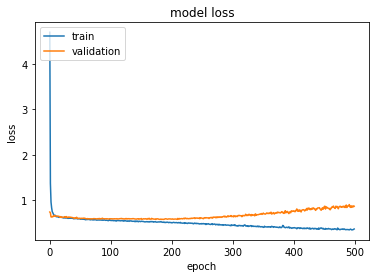

In [19]:
# Visualização de perdas nos epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.show()